In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Markdown, display

def printHeadline(str):
    display(Markdown(f"## {str}"))


In [32]:
base = "data/"
files = ['pbs', '2mM', '4mM', '6mM', '8mM', '12mM']
labels = ['(G:1,I:min)', '(G:1,I:mid)', '(G:1,I:max)', '(G:2,I:min)', '(G:2,I:mid)', '(G:2,I:max)', '(G:3,I:min)', '(G:3,I:mid)', '(G:3,I:max)']
channels = ["560nm","585nm","610nm","645nm","680nm","705nm","730nm","760nm","810nm","860nm","900nm","940nm"]

def get_data():
    data = {}
    for filename in files:
        filepath = base + filename + ".csv"
        with open(filepath) as f:
            file_data = {}
            for line in f:
                entries = line.split('#')[:-1]
                for entry in entries:
                    label_last_index = entry.index(")")
                    label, values = entry[:label_last_index + 1], entry[label_last_index + 1:]
                    if label in file_data.keys():
                        file_data[label].append(values.split(",")[:-1])
                    else:
                        file_data[label] = [values.split(",")[:-1]]
                        
            for label in file_data.keys():
                file_data[label] = np.array(file_data[label], dtype=float)
                
            data[filename] = file_data
    return data

data = get_data()

for out_key, out_value in data.items():
    for in_key, in_value in out_value.items():
        data[out_key][in_key] = np.mean(data[out_key][in_key], axis=0)
        
# data shape
# { [files]: { [labels]: [channels] } }

In [31]:
previous_base = "../glucose_measuring/data/"

def get_previous_data():
    data = {}
    for filename in sorted(os.listdir(previous_base)):
        filepath = previous_base + filename
        filename_without_ext = filename.split('.')[0]
        data[filename_without_ext] = np.loadtxt(filepath, delimiter=',')[:, 6:-1] # keep only the same channels as in the new data
    return data

previous_data = get_previous_data()

for key, value in previous_data.items():
    previous_data[key] = np.mean(value, axis=0)

In [34]:
# Compare with data from previous measurements
label = '(G:3,I:min)' # same settings as in previous measurements
current_data = {}
for key, value in data.items():
    if label in value.keys():
        current_data[key] = value[label]

## Comparison with previous measurements, separated by channel

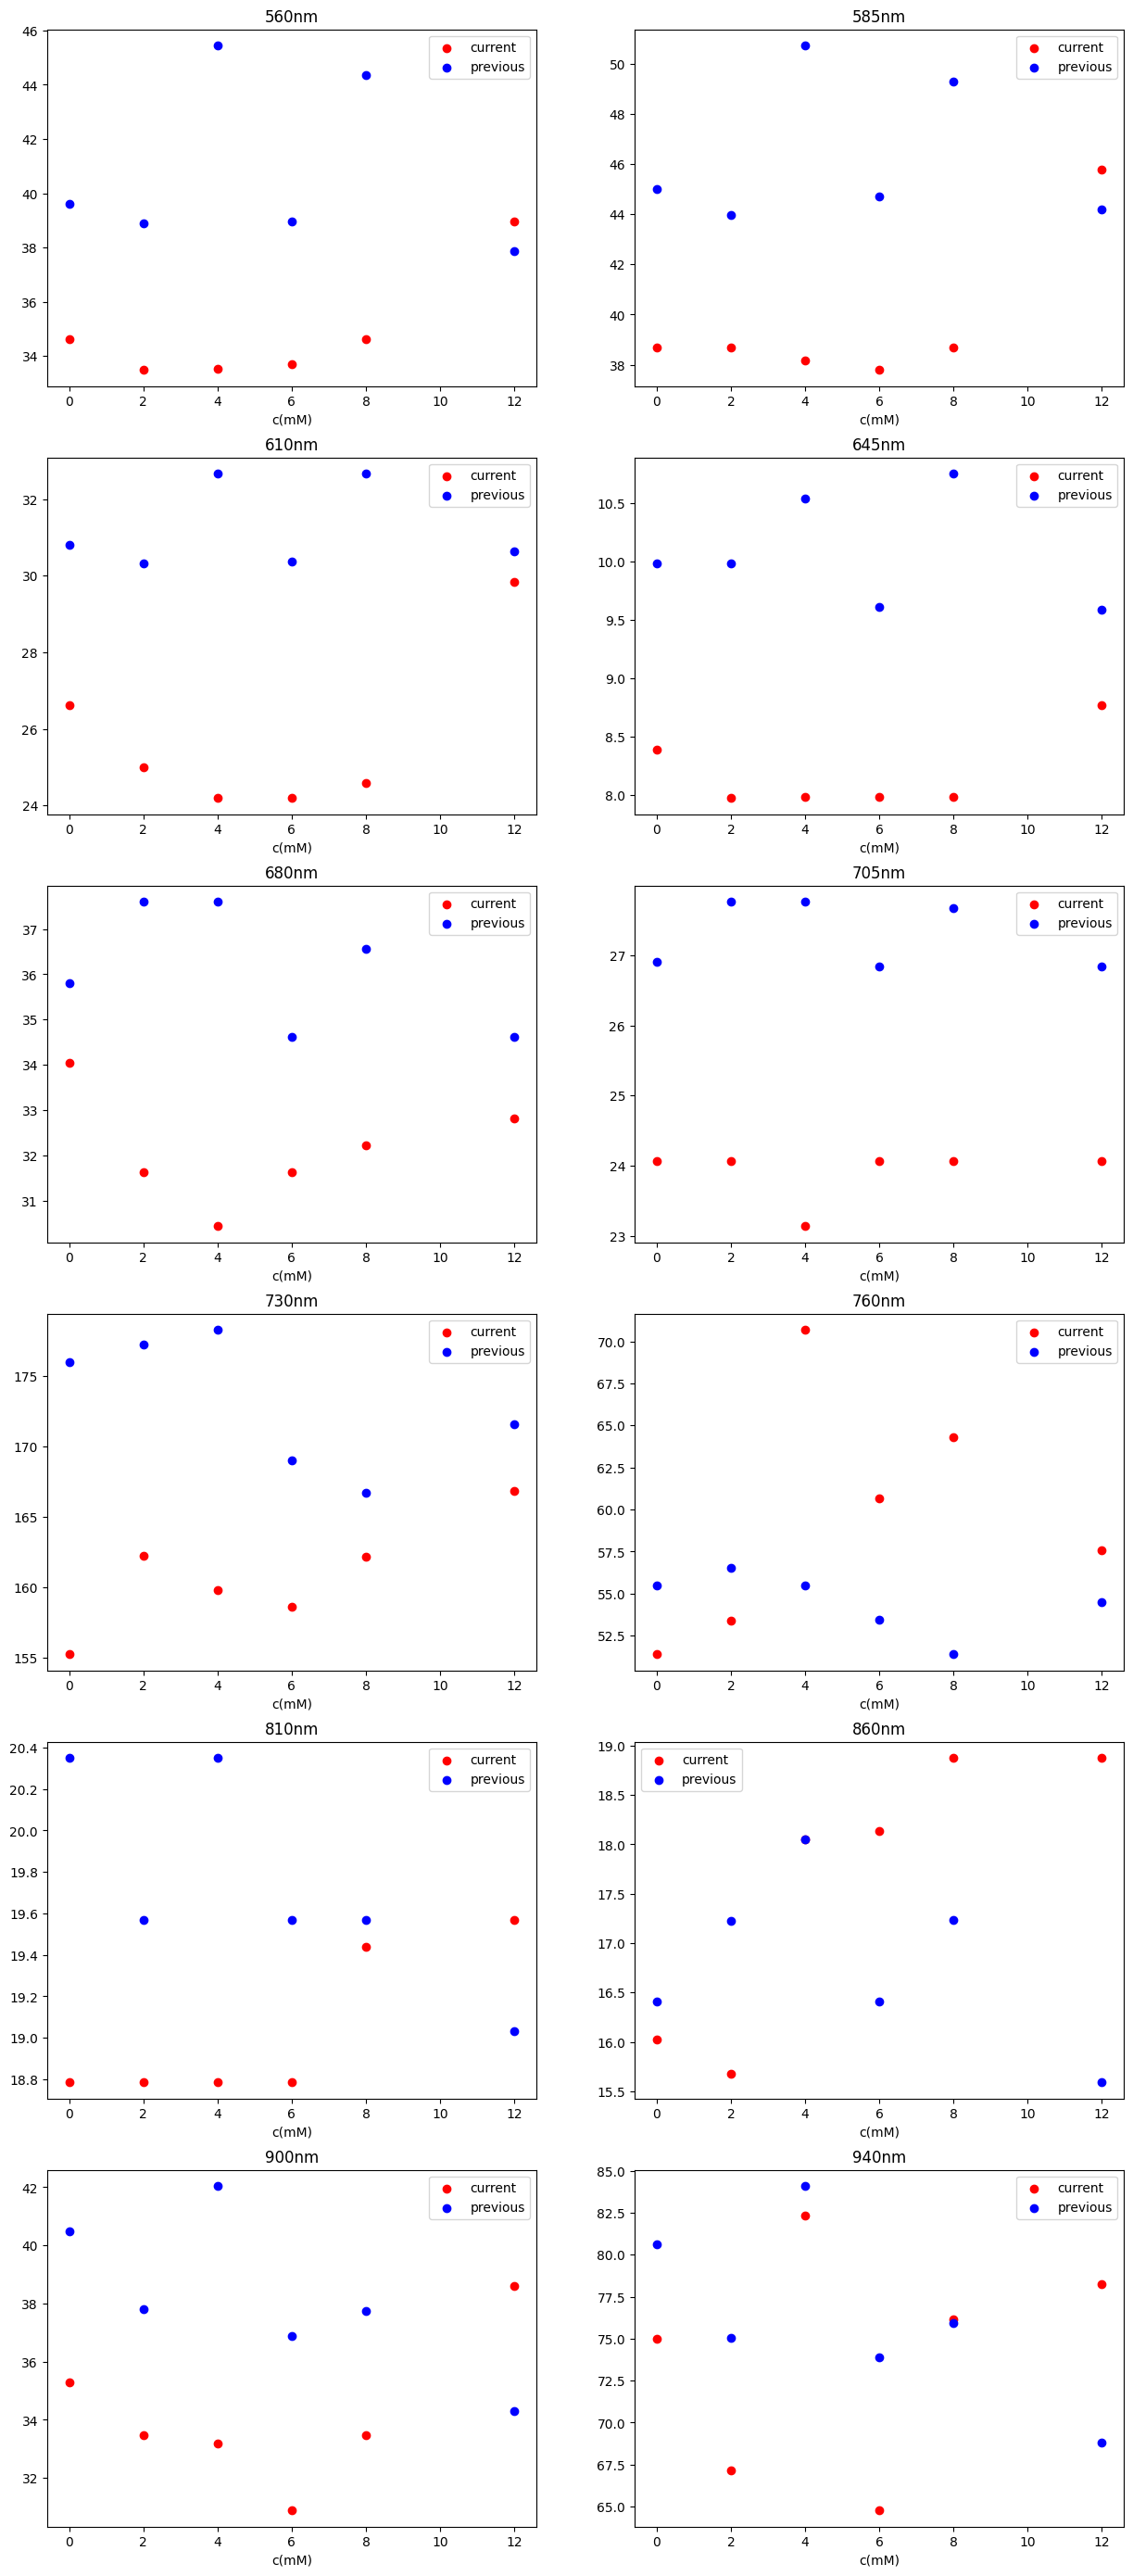

In [86]:
printHeadline("Comparison with previous measurements, separated by channel")

plt.figure(figsize=(15, 35))

for ix, channel in enumerate(channels):
    plt.subplot(6, 2, ix + 1)
    plt.title(channel)
    plt.xlabel("c(mM)")
    for file in files:
        x = 0 if file == "pbs" else int(file.replace("mM", ""))
        curr_value = current_data[file][ix]
        prev_value = previous_data[file][ix]
        # print(ix, channel, curr_value, prev_value, y)
        plt.scatter(x, curr_value, color="r")
        plt.scatter(x, prev_value, color="b")
        plt.legend(["current", "previous"])
        
plt.show()
        

In [62]:
label_max_intensity = '(G:3,I:max)'
data_max_intensity = {}
for key, value in data.items():
    if label in value.keys():
        data_max_intensity[key] = value[label_max_intensity]

## Measurement with max LED intensities and max gain(resolution), separated by channel

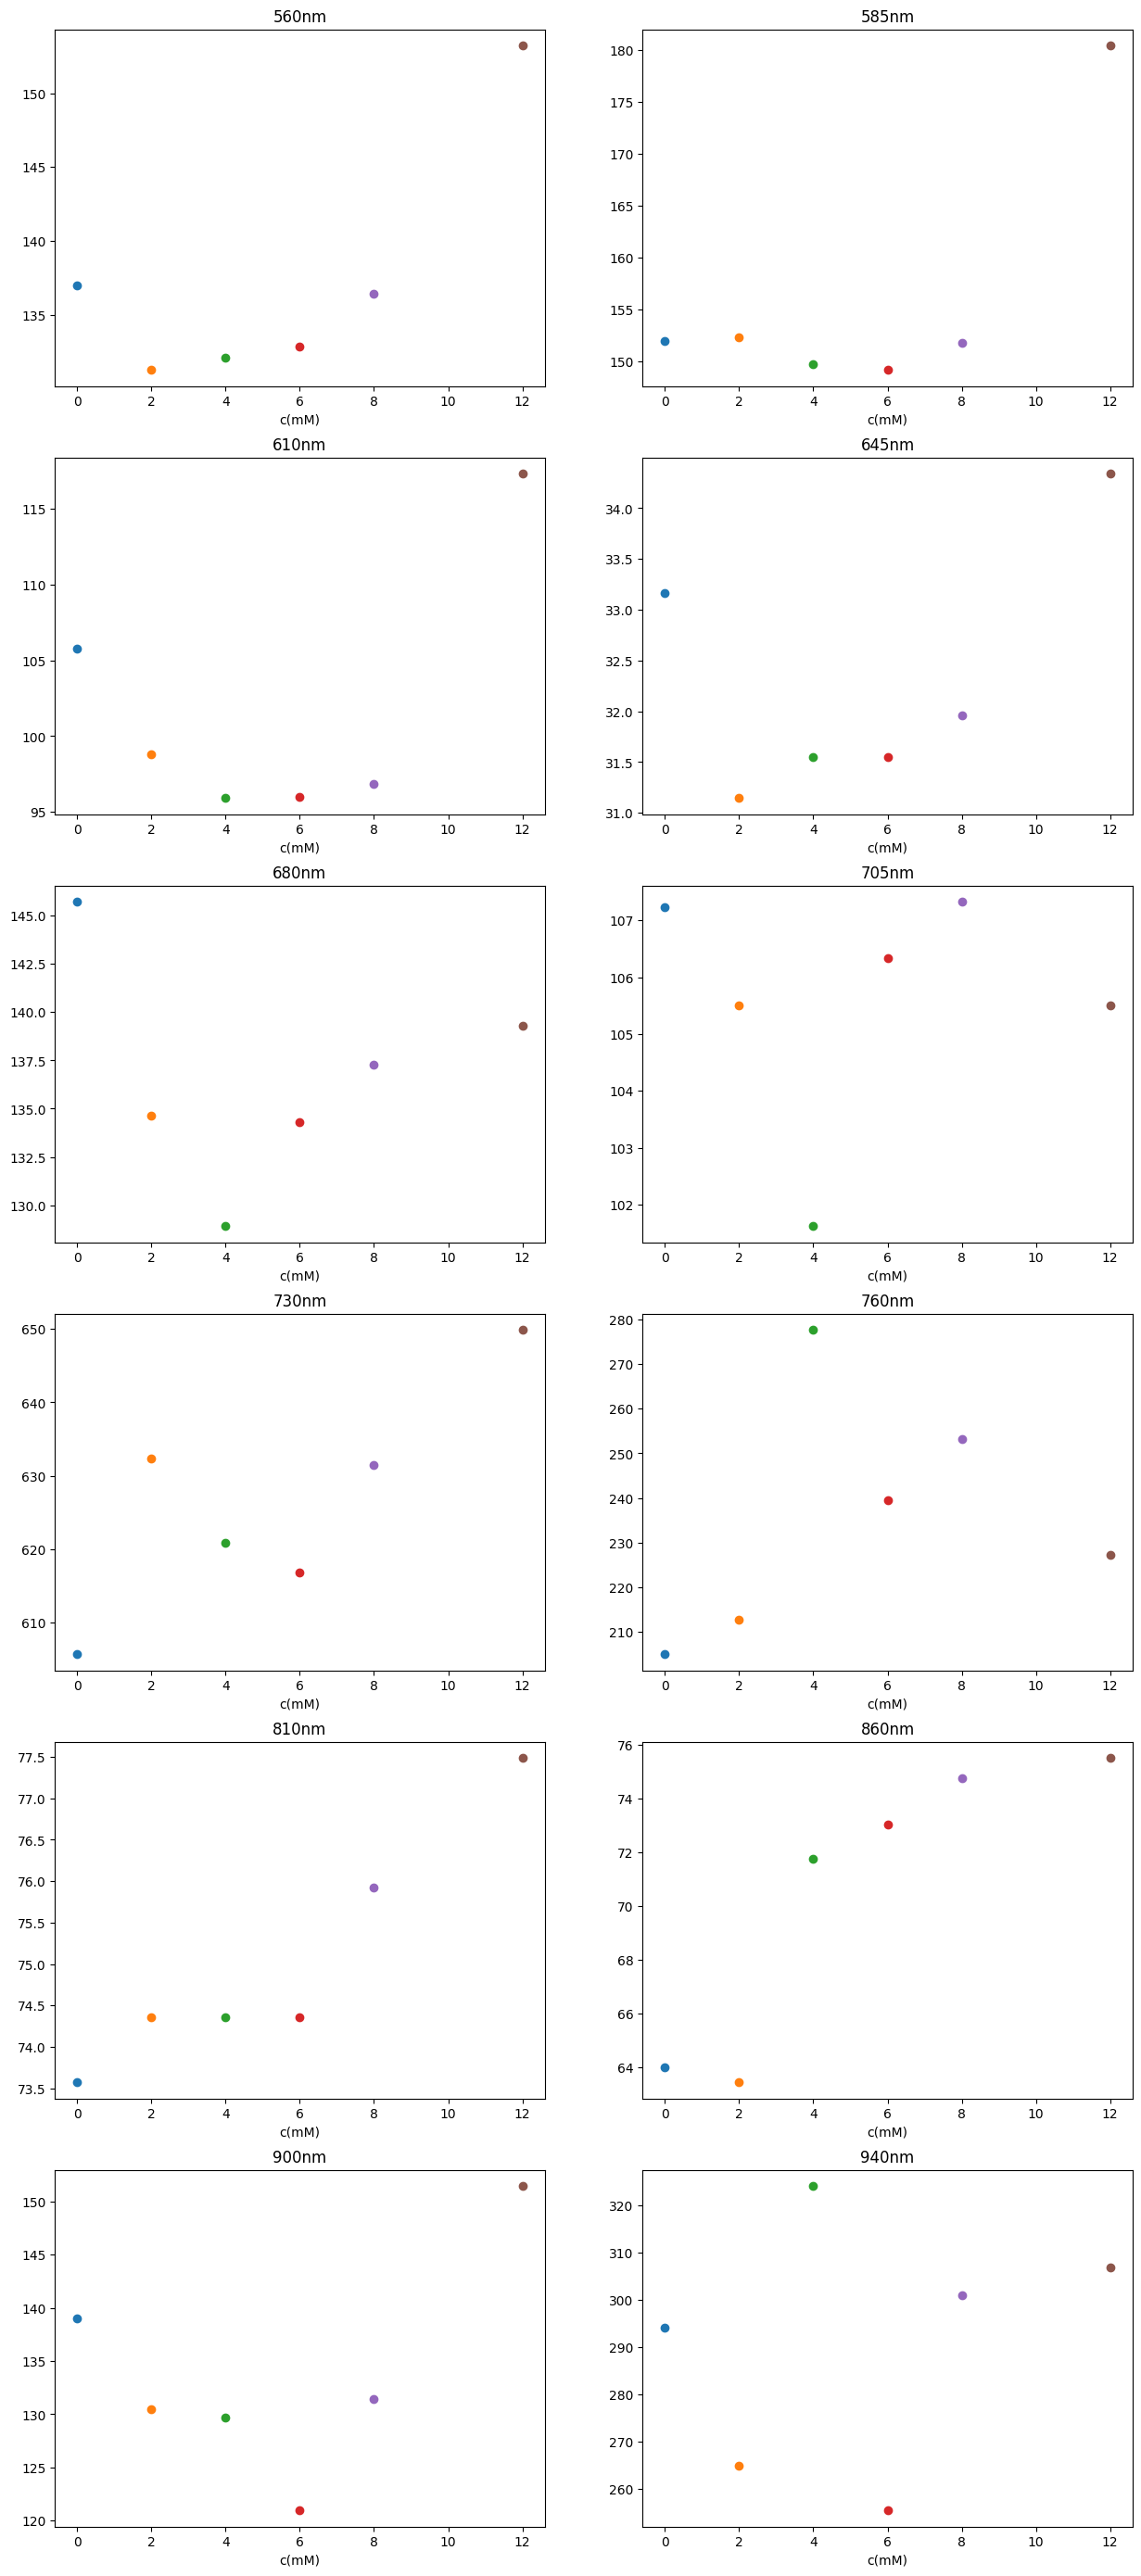

In [88]:
printHeadline("Measurement with max LED intensities and max gain(resolution), separated by channel")

plt.figure(figsize=(15, 35))

for ix, channel in enumerate(channels):
    plt.subplot(6, 2, ix + 1)
    plt.title(channel)
    plt.xlabel("c(mM)")
    for file in files:
        x = 0 if file == "pbs" else int(file.replace("mM", ""))
        value = data_max_intensity[file][ix]
        # print(ix, channel, curr_value, prev_value, y)
        plt.scatter(x, value)
        
plt.show()

## PCA of max intensity data

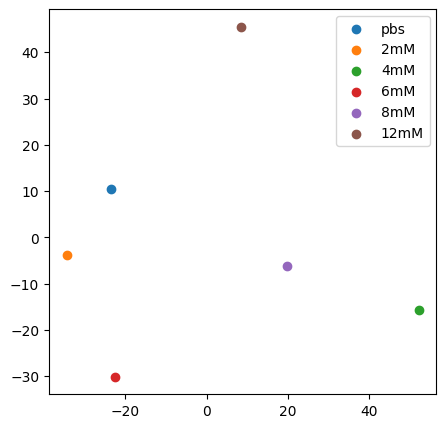

In [89]:
from sklearn.decomposition import PCA

all_data = np.concatenate([data_max_intensity[file].reshape(1, -1) for file in files], axis=0)

pca = PCA(n_components=2)
pca.fit(all_data)

printHeadline("PCA of max intensity data")

plt.figure(figsize=(5, 5))

for file in files:
    transformed = pca.transform(data_max_intensity[file].reshape(1, -1))
    plt.scatter(transformed[:, 0], transformed[:, 1])
    
plt.legend(files)
plt.show()